In [219]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy as sp
import pandas_profiling
import random
import time
import copy
import category_encoders as ce
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [148]:
train = pd.read_csv('training_set.csv')
meta_train = pd.read_csv("training_set_metadata.csv")

In [3]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [4]:
train.shape

(1421705, 6)

In [5]:
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [6]:
meta_train.shape

(7848, 12)

In case there is any reader other than me, these are just (probably obvious) notes.  Training provides the time series of timestamp (mjd, modern day julian), the specific passband the star was viewed in at a given time (passband, values = [0,1,2,3,4,5]), flux is the brightness with a dust correction (mvbev, in meta_training), flux_error is the error in the flux (n.b.--not too sure how we should take this into account.  Do we create a range?  Should we try and standardize somehow?  It seems we take take this to be a mean and a variance, is there a way we can oncorporate this for actual testing?), detected I dont really undersand, but is "the object's brightness is significantly different at the 3-sigma level relative to the reference template."  Will need to read more into that one.

In [7]:
#pandas_profiling.ProfileReport(meta_training)

In [8]:
merged_train = train.merge(meta_train, how = "left", on = "object_id")

In [9]:
merged_train.head()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92


In [10]:
merged_train['MW'] = np.where(np.isnan(merged_train.distmod), 1.0, 0.0)
# This establishes if the planetary source is in the milky way (MW) or not

In [11]:
merged_train.head()

,object_id,mjd,passband,flux,flux_err,detected,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,MW
0,615,59750.4229,2,-544.810303,3.622952,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92,1.0
1,615,59750.4306,1,-816.434326,5.553370,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92,1.0
2,615,59750.4383,3,-471.385529,3.801213,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92,1.0
3,615,59750.4450,4,-388.984985,11.395031,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92,1.0
4,615,59752.4070,2,-681.858887,4.041204,1,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92,1.0


In [12]:
trimmed_train = merged_train.copy()
trimmed_train.drop('mjd', axis = 1, inplace = True)
trimmed_train.fillna(0, inplace = True)
object_id_vec = pd.Series((trimmed_train.object_id.copy()).unique())

In [13]:
random.seed(151)
msk = np.random.rand(len(object_id_vec)) < 0.8
train_obj = object_id_vec[msk]
test_obj = object_id_vec[~msk]

## Testing Methodology
The teating set is absurdly large and unwieldy for this kind of work.  I am going to break the training set up into two smaller chunks, this should be a good guide for the time being.  Until I explicitly say later, this "training" and "testing" are just subsets of the provided training data.

In [14]:
# pd.options.mode.chained_assignment = None

sub_train = trimmed_train.loc[trimmed_train['object_id'].isin(train_obj)]
sub_test = trimmed_train.loc[trimmed_train['object_id'].isin(test_obj)]
train_target = copy.deepcopy(sub_train.target)
test_target = copy.deepcopy(sub_test.target)

sub_train.drop('target', axis = 1, inplace = True)
sub_test.drop('target', axis = 1, inplace = True)

In [91]:
train_trim = copy.deepcopy(sub_train)
test_trim = copy.deepcopy(sub_test)

#cols_to_drop = ['object_id', 'passband', 'flux', 'flux_err', 'detected']
#train_trim.drop(cols_to_drop, axis = 1, inplace = True)
#test_trim.drop(cols_to_drop, axis = 1, inplace = True)

scaler = StandardScaler()

cols_to_scale = ['hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv']

for col in cols_to_scale:
    train_trim[col + '_scaled'] = scaler.fit_transform(train_trim[[col]])
    test_trim[col + '_scaled'] = scaler.fit_transform(test_trim[[col]])
    train_trim.drop(col, axis = 1, inplace = True)
    test_trim.drop(col, axis = 1, inplace = True)

_train = copy.deepcopy(train_trim)    
_test = copy.deepcopy(test_trim)

train_trim.drop('object_id', axis = 1, inplace = True)
test_trim.drop('object_id', axis = 1, inplace = True)
                 
le =  ce.OneHotEncoder(return_df = True, impute_missing = False, handle_unknown = "ignore")
train_encoded = le.fit_transform(train_trim)
test_encoded = le.fit_transform(test_trim)

# Random Forest

In [17]:
nTrees = 200
max_depth = 10
min_node_size = 10
verbose = 0

start_time = time.time()
clf = RandomForestClassifier(n_estimators = nTrees, max_depth = max_depth, random_state = 0, \
                             verbose = verbose, min_samples_leaf = min_node_size, n_jobs = -2)
clf.fit(train_encoded, train_target)
end_time = time.time()

test_rf_predicted = clf.predict(test_encoded)

[0.00741316 0.07223984 0.03601802 0.04967922 0.0288898  0.02599058
 0.02458112 0.03698751 0.01439181 0.20957529 0.08432255 0.15333024
 0.09285071 0.12850521 0.03522493]


In [37]:
acc = accuracy_score(test_rf_predicted, test_target)
prec = precision_score(test_rf_predicted, test_target, average = 'macro')
rec= recall_score(test_rf_predicted, test_target, average = 'macro')
F1 = f1_score(test_rf_predicted, test_target, average = 'weighted')

print("Accuracy on Testing Data = %.4f%%"%(100 * acc))
print("Precision on Testing Data = %.4f%%"%(100 * prec))
print("Recall on Testing Data = %.4f%%"%(100 * rec))
print("F1 on Testing Data = %.4f%%"%(100 * F1))
print("Time elapsed = %.1f"%(end_time - start_time) + " seconds")

Accuracy on Testing Data = 59.2130%
Precision on Testing Data = 32.7609%
Recall on Testing Data = 41.5169%
F1 on Testing Data = 65.3965%
Time elapsed = 202.4 seconds


# Neural Network

In [54]:
start_time = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(train_encoded, train_target)
end_time = time.time()

test_nn_predicted = mlp.predict(test_encoded)

In [55]:
acc = accuracy_score(test_nn_predicted, test_target)
prec = precision_score(test_nn_predicted, test_target, average = 'macro')
rec= recall_score(test_nn_predicted, test_target, average = 'macro')
F1 = f1_score(test_nn_predicted, test_target, average = 'weighted')

print("Accuracy on Testing Data = %.4f%%"%(100 * acc))
print("Precision on Testing Data = %.4f%%"%(100 * prec))
print("Recall on Testing Data = %.4f%%"%(100 * rec))
print("F1 on Testing Data = %.4f%%"%(100 * F1))
print("Time elapsed = %.1f"%(end_time - start_time) + " seconds")

Accuracy on Testing Data = 56.2845%
Precision on Testing Data = 32.3504%
Recall on Testing Data = 42.8848%
F1 on Testing Data = 60.8592%
Time elapsed = 640.1 seconds


# Ensamble

In [58]:
learning_rate = 0.05
max_depth = 5
min_node_size = 5

start_time = time.time()
gbc = GradientBoostingClassifier(n_estimators = 10, loss = 'deviance', \
                                     learning_rate = learning_rate, max_depth = max_depth, \
                                     min_samples_leaf = min_node_size)
gbc.fit(train_encoded, train_target.values.ravel())
end_time = time.time()

test_gbc_predicted = gbc.predict(test_encoded)

In [59]:
acc = accuracy_score(test_gbc_predicted, test_target)
prec = precision_score(test_gbc_predicted, test_target, average = 'macro')
rec= recall_score(test_gbc_predicted, test_target, average = 'macro')
F1 = f1_score(test_gbc_predicted, test_target, average = 'weighted')

print("Accuracy on Testing Data = %.4f%%"%(100 * acc))
print("Precision on Testing Data = %.4f%%"%(100 * prec))
print("Recall on Testing Data = %.4f%%"%(100 * rec))
print("F1 on Testing Data = %.4f%%"%(100 * F1))
print("Time elapsed = %.1f"%(end_time - start_time) + " seconds")

Accuracy on Testing Data = 58.3145%
Precision on Testing Data = 32.5702%
Recall on Testing Data = 40.0344%
F1 on Testing Data = 64.4652%
Time elapsed = 697.8 seconds


# Pass band statistics

In [111]:
coi = ['object_id', 'passband', 'flux', 'flux_err', 'hostgal_photoz_scaled', \
       'hostgal_photoz_err_scaled', 'distmod_scaled', 'mwebv_scaled']

train_groups = _train[coi].groupby(['object_id', 'passband']).agg({np.mean, np.std}).unstack().reset_index()
test_groups = _test[coi].groupby(['object_id', 'passband']).agg({np.mean, np.std}).unstack().reset_index()

oid_target = meta_train[['object_id', 'target']]

train_groups_target = train_groups.merge(oid_target, how = "left", on = "object_id")['object_id']
test_groups_target = test_groups.merge(oid_target, how = "left", on = "object_id")['object_id']

train_groups.drop('object_id', axis = 1, inplace = True)
test_groups.drop('object_id', axis = 1, inplace = True)
                 
train_groups_encoded = le.fit_transform(train_groups)
test_groups_encoded = le.fit_transform(test_groups)

# Random Forest #2

In [112]:
nTrees = 200
max_depth = 10
min_node_size = 10
verbose = 0

start_time = time.time()
clf = RandomForestClassifier(n_estimators = nTrees, max_depth = max_depth, random_state = 0, \
                             verbose = verbose, min_samples_leaf = min_node_size, n_jobs = -2)
clf.fit(train_groups_encoded, train_groups_target)
end_time = time.time()

test_rf_predicted = clf.predict(test_groups_encoded)

acc = accuracy_score(test_rf_predicted, test_groups_target)
prec = precision_score(test_rf_predicted, test_groups_target, average = 'macro')
rec= recall_score(test_rf_predicted, test_groups_target, average = 'macro')
F1 = f1_score(test_rf_predicted, test_groups_target, average = 'weighted')

print("Accuracy on Testing Data = %.4f%%"%(100 * acc))
print("Precision on Testing Data = %.4f%%"%(100 * prec))
print("Recall on Testing Data = %.4f%%"%(100 * rec))
print("F1 on Testing Data = %.4f%%"%(100 * F1))
print("Time elapsed = %.1f"%(end_time - start_time) + " seconds")

Accuracy on Testing Data = 0.0000%
Precision on Testing Data = 0.0000%
Recall on Testing Data = 0.0000%
F1 on Testing Data = 0.0000%
Time elapsed = 158.0 seconds


# Bring in Stats

In [113]:
train_passband_stats = pd.read_csv('train_passband_stats.csv')

In [151]:
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [183]:
scale = StandardScaler()

meta_train.loc[np.isnan(meta_train.distmod), 'distmod'] = 1
meta_train['mwebv_scale'] = scale.fit_transform(meta_train[['mwebv']])
meta_train_filtered = copy.deepcopy(meta_train[['object_id', 'ra', 'decl' ,
                                                'gal_l', 'gal_b', 'mwebv_scale']])

In [184]:
meta_merge = meta_train_filtered.merge(train_passband_stats, how = "left", on = "object_id")

In [185]:
meta_merge.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'mwebv_scale',
       'fluxmean_Y', 'fluxmean_g', 'fluxmean_i', 'fluxmean_r', 'fluxmean_u',
       'fluxmean_z', 'fluxmin_Y', 'fluxmin_g', 'fluxmin_i', 'fluxmin_r',
       'fluxmin_u', 'fluxmin_z', 'fluxmax_Y', 'fluxmax_g', 'fluxmax_i',
       'fluxmax_r', 'fluxmax_u', 'fluxmax_z', 'fluxstd_Y', 'fluxstd_g',
       'fluxstd_i', 'fluxstd_r', 'fluxstd_u', 'fluxstd_z', 'fluxsem_Y',
       'fluxsem_g', 'fluxsem_i', 'fluxsem_r', 'fluxsem_u', 'fluxsem_z',
       'fluxvar_Y', 'fluxvar_g', 'fluxvar_i', 'fluxvar_r', 'fluxvar_u',
       'fluxvar_z', 'fluxskew_Y', 'fluxskew_g', 'fluxskew_i', 'fluxskew_r',
       'fluxskew_u', 'fluxskew_z', 'fluxmad_Y', 'fluxmad_g', 'fluxmad_i',
       'fluxmad_r', 'fluxmad_u', 'fluxmad_z', 'flux_errWeight_Y',
       'flux_errWeight_g', 'flux_errWeight_i', 'flux_errWeight_r',
       'flux_errWeight_u', 'flux_errWeight_z', 'target'],
      dtype='object')

In [186]:
meta_merge['luminosity_Y'] = 4 * np.pi * (meta_merge['fluxmean_Y'] ** 2)
meta_merge['luminosity_g'] = 4 * np.pi * (meta_merge['fluxmean_g'] ** 2)
meta_merge['luminosity_i'] = 4 * np.pi * (meta_merge['fluxmean_i'] ** 2)
meta_merge['luminosity_r'] = 4 * np.pi * (meta_merge['fluxmean_r'] ** 2)
meta_merge['luminosity_u'] = 4 * np.pi * (meta_merge['fluxmean_u'] ** 2)
meta_merge['luminosity_z'] = 4 * np.pi * (meta_merge['fluxmean_z'] ** 2)

In [202]:
meta_merge_copy = copy.deepcopy(meta_merge)

meta_merge_copy.drop('object_id', inplace = True, axis = 1)

le =  ce.OneHotEncoder(return_df = True, impute_missing = False, handle_unknown = "ignore")

meta_merge_target = meta_merge_copy['target']
meta_merge_feature = meta_merge_copy[meta_merge_copy.columns.drop('target')]

encoded_train = le.fit_transform(meta_merge_feature)

encoded_train.fillna(0, inplace = True)

feature_train, feature_test, target_train, target_test = train_test_split(
    encoded_train, 
    meta_merge_target,
    random_state = 42,
    test_size = 0.2,
    shuffle=True)

In [204]:
nTrees = 200
max_depth = 12
min_node_size = 5
verbose = 0

start_time = time.time()
clf = RandomForestClassifier(n_estimators = nTrees, max_depth = max_depth, random_state = 0, \
                             verbose = verbose, min_samples_leaf = min_node_size, n_jobs = -2)
clf.fit(feature_train, target_train)
end_time = time.time()

test_rf_predicted = clf.predict(feature_test)

acc = accuracy_score(test_rf_predicted, target_test)
prec = precision_score(test_rf_predicted, target_test, average = 'macro')
rec= recall_score(test_rf_predicted, target_test, average = 'macro')
F1 = f1_score(test_rf_predicted, target_test, average = 'weighted')

print("Accuracy on Testing Data = %.4f%%"%(100 * acc))
print("Precision on Testing Data = %.4f%%"%(100 * prec))
print("Recall on Testing Data = %.4f%%"%(100 * rec))
print("F1 on Testing Data = %.4f%%"%(100 * F1))
print("Time elapsed = %.1f"%(end_time - start_time) + " seconds")

Accuracy on Testing Data = 68.2803%
Precision on Testing Data = 50.6736%
Recall on Testing Data = 61.4147%
F1 on Testing Data = 72.1825%
Time elapsed = 4.2 seconds


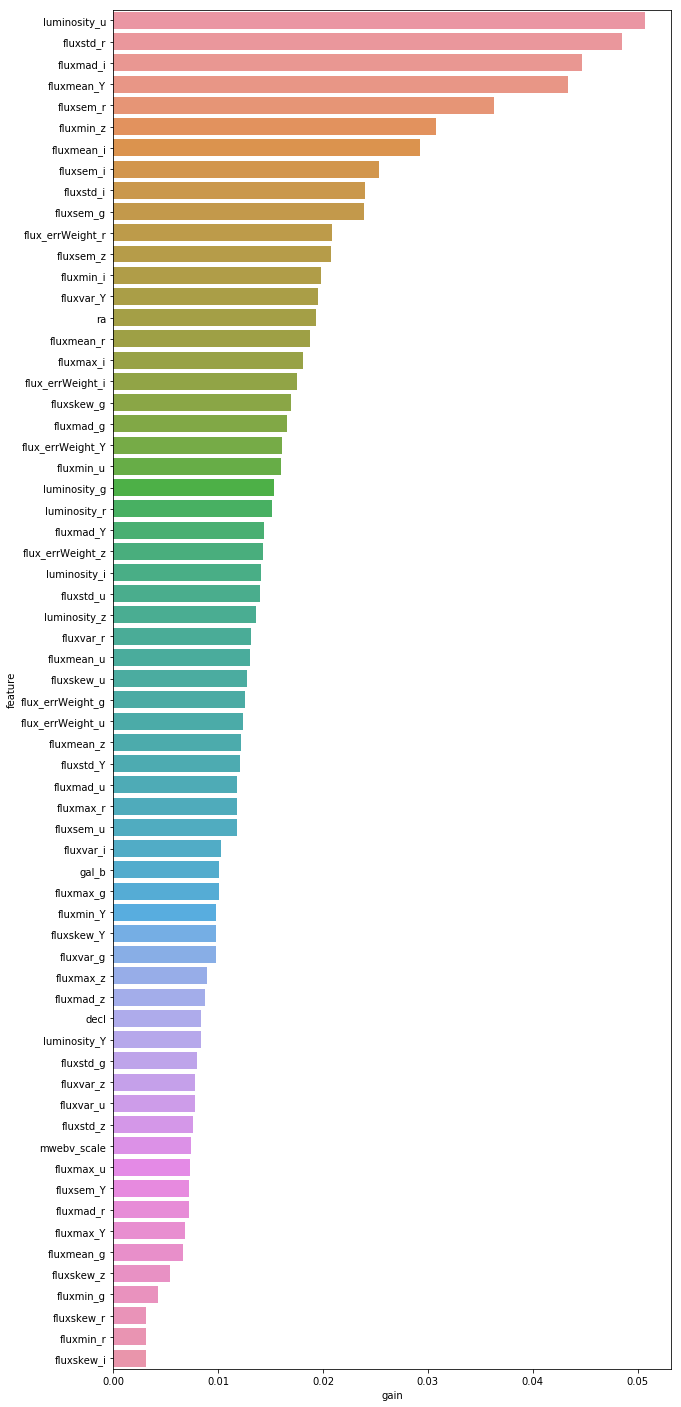

In [220]:
feature_importance = list(clf.feature_importances_)
feature_names = list(feature_train.columns)
lenFeats = feature_train.shape[1]-1
top_features = lenFeats
sorted_index= sorted(range(len(feature_importance)), key=lambda k: feature_importance[k], reverse=True)
top_feature_importance = [feature_importance[i] for i in sorted_index[0:top_features]]
top_feature_names = [feature_names[i] for i in sorted_index[0:top_features]]

plt.figure(figsize=(10, 25))
imp_df = pd.DataFrame()
imp_df['feature'] = top_feature_names
imp_df['gain'] = clf.feature_importances_[0:lenFeats]
#imp_df
sns.barplot(x='gain', y='feature', data=imp_df.sort_values('gain', ascending=False))